<h1>Information Retrieval Architecture Diagram</h1>
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*c9A2GZ7GQYOEEeKwQ2ZfjQ.png" alt="Alternative text" />

In [41]:
# Importing libraries
import os
import gzip
import json
import random
import numpy as np
import pandas as pd
import torch
import faiss
from torch import nn
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets

from google.colab import files

uploaded = files.upload()

Saving Drugs Master List.csv to Drugs Master List.csv


In [42]:
df = pd.read_csv('Drugs Master List.csv')

In [43]:
# Display the five records of the dataset.
df.head()

,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,X,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,NaN,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",NaN,41%,Rx,X,N,X,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.9,623.0,https://www.drugs.com/accutane.html,https://www.drugs.com/condition/acne.html
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives","Cleocin T, Clindacin ETZ, Clindacin P, Clindag...",39%,Rx,B,N,NaN,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.4,146.0,https://www.drugs.com/mtm/clindamycin-topical....,https://www.drugs.com/condition/acne.html


In [13]:
def missing_value_imputation(data):
  """ This is a utility function for missing value imputation."""
  
  missing_cols = data.columns[data.isnull().any()].tolist()
  if missing_cols:
    print("Missing columns have been identified!")

  # computes the unique medical conditions and stores it in a dictionary data structure.
  unique_medical_condition = data['medical_condition'].unique() 

  # the dict store contains the columns that contain missing values.
  dict_store = {condition: {'side_effects': set(), 'generic_name': set(), 'drug_classes': set(), 'brand_names': set(),
                              'pregnancy_category': set(), 'alcohol': set(), 'related_drugs': set(),
                              'rating': set(), 'no_of_reviews': set()} for condition in unique_medical_condition}

  # iterating over each row and checking if the medical condition is related, check the dict store if it contains
  # the associated missing column and randomly picks the value in the dict store.
  for _, value in data.iterrows():
      condition = value['medical_condition']
      dict_store[condition]['side_effects'].add(value['side_effects'])
      dict_store[condition]['generic_name'].add(value['generic_name'])
      dict_store[condition]['drug_classes'].add(value['drug_classes'])
      dict_store[condition]['brand_names'].add(value['brand_names'])
      dict_store[condition]['pregnancy_category'].add(value['pregnancy_category'])
      dict_store[condition]['alcohol'].add(value['alcohol'])
      dict_store[condition]['related_drugs'].add(value['related_drugs'])
      dict_store[condition]['rating'].add(value['rating'])
      dict_store[condition]['no_of_reviews'].add(value['no_of_reviews'])

      for index, value in data.iterrows():
          for col in missing_cols:
              if pd.isnull(value[col]):
                  condition = value['medical_condition']
                  col_values = dict_store[condition][col]
                  if col_values:
                      imputed_value = random.choice(list(col_values))
                  else:
                      mode_value = data[data['medical_condition'] == condition][col].mode().values
                      if len(mode_value) > 0:
                          imputed_value = mode_value[0]
                      else:
                          imputed_value = None
                  data.at[index, col] = imputed_value

      return data


def check_missing(data):
  """ Check if the data contains missing values"""
  
  missing_dict = data.isnull().sum().to_dict()
  return all(missing_dict[col] == 0 for col in ['side_effects', 'generic_name', 'drug_classes', 'brand_names',
                                                  'pregnancy_category', 'alcohol', 'related_drugs', 'rating',
                                                  'no_of_reviews'])

def preprocessing(data):
  """ Returns the preprocess data and ensuring the data is filled properly """

  while True:
    missing_data = data.copy()
    data = missing_value_imputation(data)
    if check_missing(data):
      break
        
    # If no progress is made in filling missing values, exit the loop
    if missing_data.equals(data):
      break
  
  return data


In [15]:
preprocessed_df = preprocessing(df)

Missing columns have been identified!


In [12]:
#preprocessed_df.isnull().sum()

In [16]:
def add_name_sideeffects(data):
  """Add the possible columns the client will interact with."""
  
  drug_classes = ''.join(data[3].split(','))
  return f"This drug is {data[0]}. People who thake this drug has {data[3]}. It has the following side effect: {data[1]}. It also belong to the following drug classes: {drug_classes}"

In [17]:
preprocessed_df['drug_description'] = preprocessed_df[['drug_name', 'side_effects', 'drug_classes', 'medical_condition']].apply(add_name_sideeffects, axis=1)

In [18]:
# preprocessed_df['drug_description']

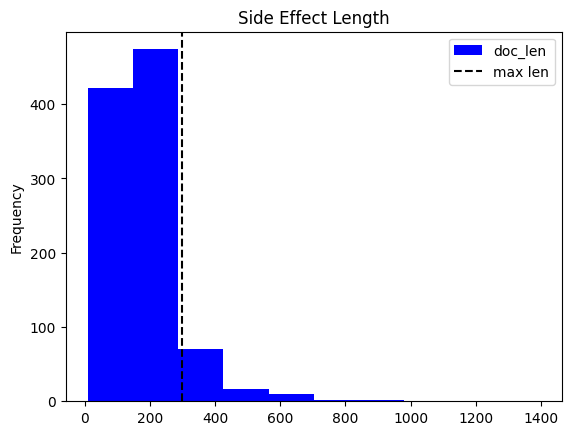

In [19]:
preprocessed_df['doc_len'] = preprocessed_df['side_effects'].apply(lambda words: len(words.split(' ')))
max_seq_len = np.round(preprocessed_df['doc_len'].mean() + preprocessed_df['doc_len'].std()).astype(int)

import seaborn as sns

preprocessed_df['doc_len'].plot.hist(color='b')
#sns.histplot(data=preprocessed_df['doc_len'], kde_kws={'linewidth': 4})
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('Side Effect Length')
plt.legend()
plt.show()

In [21]:
# Install the sentence transformer
!pip install sentence_transformers

# import the sentence trnsformer library
from sentence_transformers import SentenceTransformer

# load the sentence tansformer pretrained model - msmarco-distilbert-base-dot-prod-v3
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# Install the Faiss-GPU
!pip install faiss-gpu

# Load the Faiss Library
import faiss

# Encode the drug description and store it in a Faiss Document
encoded_data = model.encode(preprocessed_df['drug_description'].tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'drug_side_effect.index')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.5 MB/s eta 0:00:00


In [23]:
def fetch_drug_info(dataframe_idx):
  """ Fetch the drug information"""
  
  info = preprocessed_df.iloc[dataframe_idx]
  meta_dict = dict()
  meta_dict['Drug_Name'] = info['drug_name']
  meta_dict['Side_Effects'] = info['side_effects']
  return meta_dict

In [24]:
import time

def search(query, topk, index, model):
  """ Search the query and apply the model in the faiss index document"""
  t = time.time()
  query_vector = model.encode([query])
  top_k = index.search(query_vector, topk)
  print('>>>> Results in Total Time: {}'.format(time.time() - t))
  top_k_ids = top_k[1].tolist()[0]
  results = [fetch_drug_info(idx) for idx in top_k_ids]
  return results

In [25]:
from pprint import pprint
query="I want information on amoxicillin"
results=search(query, topk=5, index=index, model=model)
print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.019990205764770508


	 {'Drug_Name': 'amoxicillin', 'Side_Effects': 'severe stomach pain; or diarrhea that is watery or bloody (even if it occurs months after your last dose). Common amoxicillin side effects may include: nausea , vomiting , diarrhea; or rash.'}
	 {'Drug_Name': 'amoxicillin / clavulanate', 'Side_Effects': 'severe stomach pain, diarrhea that is watery or bloody (even if it occurs months after your last dose); pale or yellowed skin, dark colored urine, fever, confusion or weakness; loss of appetite, upper stomach pain; little or no urination; or easy bruising or bleeding. Common amoxicillin and clavulanate side effects may include: nausea, vomiting; diarrhea; rash, itching; vaginal itching or discharge; or diaper rash .'}
	 {'Drug_Name': 'Amoxil', 'Side_Effects': 'severe stomach pain; or diarrhea that is watery or bloody (even if it occurs months after your last dose). Common Amoxil side effects may include: nausea , vomiting , diarrhea; or r

In [26]:
from pprint import pprint

query="I have acne"
results=search(query, topk=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.016958951950073242


	 {'Drug_Name': 'Neutrogena Rapid Clear Stubborn Acne', 'Side_Effects': 'Neutrogena Acne Mask can cause a rare but serious allergic reaction or severe skin irritation. These reactions may occur just a few minutes after you apply the medicine, or within a day or longer afterward. Stop using this medicine and get emergency medical help if you have signs of an allergic reaction : hives, itching; difficult breathing, feeling light-headed; swelling of your face, lips, tongue, or throat. Stop using benzoyl peroxide and call your doctor at once if you have any of these side effects on the treated skin: severe itching or burning; severe stinging or redness; swelling; or peeling. Common side effects of Neutrogena Acne Mask may include: mild stinging or burning; itching or tingly feeling; skin dryness, peeling, or flaking; or redness or other irritation.'}
	 {'Drug_Name': 'Acnomel Acne Mask', 'Side_Effects': 'Along with its needed effects, a med

In [27]:
!pip install tqdm

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [29]:
# parameters for generation
batch_size = 16 #Batch size
num_queries = 5 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 64   #Max length for output query

# possible queries in the paragraph to finetune the sentence transformer model.
paragraphs = """Do you have any over-the-counter pain relievers?
Where can I find cough syrup for adults?
Is there a specific aisle for allergy medications?
Can you recommend any antacids for heartburn relief?
Do you carry any non-drowsy cold and flu medicines?
Where can I find children's fever reducers?
Can you point me towards the aisle with vitamins and supplements?
Do you have any nasal sprays for congestion?
Is there a section for digestive health products?
Can you recommend any sleep aids?
Where can I find band-aids and other first aid supplies?
Do you carry any antihistamines for seasonal allergies?
Is there a specific shelf for eye drops?
Can you recommend any over-the-counter creams for muscle pain?
Do you have any topical ointments for skin rashes?
Where can I find oral rehydration solutions?
Is there a section for feminine hygiene products?
Can you recommend any probiotics for gut health?
Do you carry any antifungal creams for athlete's foot?
Is there a specific aisle for diabetic supplies?
Where can I find pregnancy tests?
Can you recommend any laxatives for constipation relief?
Do you have any products for smoking cessation?
Is there a section for oral care products like toothpaste and mouthwash?
Can you point me towards the aisle with sunscreen and skincare products?
Where can I find home diagnostic kits, like blood pressure monitors?
Do you carry any products for weight management?
Is there a specific shelf for hair care products?
Can you recommend any natural remedies for cold and flu symptoms?
Do you have any products for stress relief or anxiety?
Where can I find condoms and other contraceptives?
Is there a section for children's vitamins and supplements?
Can you point me towards the aisle with smoking accessories, like lighters?
Do you carry any oral antiseptics for sore throat relief?
Is there a specific aisle for incontinence products?
Where can I find baby care products, like diapers and baby wipes?
Can you recommend any products for joint and arthritis pain?
Do you have any non-prescription allergy eye drops?
Is there a section for nutritional drinks and shakes?
Can you point me towards the aisle with wound care supplies?
Where can I find foot care products, like orthotics or corn pads?
Do you carry any products for urinary tract health?
Is there a specific shelf for homeopathic remedies?
Can you recommend any vitamins or supplements for hair and nail health?
Do you have any products for cold sore treatment?
Where can I find hearing aids and accessories?
Can you point me towards the aisle with pet medications?
Is there a section for medical devices, like thermometers or blood glucose monitors?
Do you carry any products for infant colic relief?
Can you recommend any over-the-counter allergy nasal sprays?
"""

def _removeNonAscii(s): 
  """ Return the preprocessed data"""
  return "".join(i for i in s if ord(i) < 128)

with open('generated_queries_all.tsv', 'w') as fOut:
    for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
        sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
        inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt')
        outputs = model.generate(
            **inputs,
            max_length=max_length_query,
            do_sample=True,
            top_p=0.95,
            num_return_sequences=num_queries)

        for idx, out in enumerate(outputs):
            query = tokenizer.decode(out, skip_special_tokens=True)
            query = _removeNonAscii(query)
            para = sub_paragraphs[int(idx/num_queries)]
            para = _removeNonAscii(para)
            fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

  0%|          | 0/173 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3732: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
100%|██████████| 173/173 [12:43<00:00,  4.42s/it]


In [31]:

train_examples = [] 
with open('generated_queries_all.tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass
        
random.shuffle(train_examples)

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)

# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])


# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)


#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/87 [00:00<?, ?it/s]

Iteration:   0%|          | 0/87 [00:00<?, ?it/s]

Iteration:   0%|          | 0/87 [00:00<?, ?it/s]

In [32]:
model = SentenceTransformer('search/search-model')

In [33]:
# unzip the model into a search folder 
!zip -r search_model.zip "./search"


  adding: search/ (stored 0%)
  adding: search/search-model/ (stored 0%)
  adding: search/search-model/sentence_bert_config.json (deflated 4%)
  adding: search/search-model/config_sentence_transformers.json (deflated 28%)
  adding: search/search-model/pytorch_model.bin (deflated 8%)
  adding: search/search-model/vocab.txt (deflated 53%)
  adding: search/search-model/tokenizer.json (deflated 71%)
  adding: search/search-model/1_Pooling/ (stored 0%)
  adding: search/search-model/1_Pooling/config.json (deflated 47%)
  adding: search/search-model/tokenizer_config.json (deflated 45%)
  adding: search/search-model/modules.json (deflated 53%)
  adding: search/search-model/README.md (deflated 58%)
  adding: search/search-model/special_tokens_map.json (deflated 42%)
  adding: search/search-model/config.json (deflated 44%)


In [36]:
# Encode the data
encoded_data = model.encode(df.drug_description.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'data_encode.index')

In [37]:
from pprint import pprint

query="i have cough what drugs can you suggest?"
results=search(query, topk=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.016882896423339844


	 {'Drug_Name': 'brompheniramine', 'Side_Effects': 'hives ; difficult breathing; swelling of your face, lips, tongue, or throat. Less serious side effects may be more likely, and you may have none at all.'}
	 {'Drug_Name': 'diphenhydramine', 'Side_Effects': 'hives; difficult breathing; swelling of your face, lips, tongue, or throat. Stop using diphenhydramine and call your doctor at once if you have: pounding heartbeats or fluttering in your chest; painful or difficult urination; little or no urinating; confusion, feeling like you might pass out; or tightness in your neck or jaw, uncontrollable movements of your tongue. Common diphenhydramine side effects may include: dizziness, drowsiness, loss of coordination; dry mouth, nose, or throat; constipation, upset stomach; dry eyes, blurred vision; or day-time drowsiness or "hangover" feeling after night-time use.'}
	 {'Drug_Name': 'Diphen', 'Side_Effects': 'hives ; difficult breathing; swe

In [38]:
from pprint import pprint

query="please recommend HIV/AIDS drugs"
results=search(query, topk=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.01802968978881836


	 {'Drug_Name': 'AccessPak for HIV PEP Basic', 'Side_Effects': "hives ; difficult breathing; swelling of your face, lips, tongue, or throat. Mild symptoms of lactic acidosis may worsen over time , and this condition can be fatal. Get emergency medical help if you have: unusual muscle pain, trouble breathing, stomach pain, vomiting , irregular heart rate, dizziness, feeling cold, or feeling very weak or tired. AccessPak for HIV PEP Basic may cause serious side effects. Call your doctor at once if you have: symptoms of new HIV infection--fever, night sweats, tiredness, muscle or joint pain, sore throat, vomiting, diarrhea, rash, swollen glands in your neck or groin; sudden or unusual bone pain; kidney problems--little or no urination, swelling in your feet or ankles, feeling tired or short of breath; or liver problems-- nausea , swelling around your midsection, upper stomach pain, loss of appetite, dark urine, clay-colored stools, jaundic